# Module 09: Data Preprocessing and Feature Engineering

This notebook supports **Module 09** and contains all code and explanatory text for:

- **Part 1**: Missing values, encoding categorical variables, scaling/normalization
- **Part 2**: Outlier detection, feature transformation, domain-driven features,
  preprocessing pipelines, and a quick sanity-check model

Datasets used:
- **Titanic dataset** (from Kaggle) – for demonstrating missing values
- **Heart Failure / Heart Disease dataset** – for the main preprocessing pipeline

Please upload or mount the CSV files in your environment as needed.

---
## Part 1: Core Preprocessing Concepts

In Part 1 we cover:
- Why preprocessing is needed
- How to handle missing values
- How to encode categorical variables
- How to scale / normalize numeric features

###Handling Missing Values (Titanic Dataset)

Real-life analogy: **attendance sheet with blank cells**.

- Some students have `P` (present), some have `A` (absent), and some cells are blank.
- If we ignore those blanks, the final attendance calculation will be wrong.
- We must decide how to handle the blanks using logic.

In the Titanic dataset:
- `Age` has missing values (numeric)
- `Embarked` has a few missing values (categorical)
- `Cabin` has many missing values (often dropped in simple demos)

We will:
1. Inspect missing values
2. Fill numeric column (`Age`) with the **median**
3. Fill categorical column (`Embarked`) with the **mode**
4. Drop `Cabin` because it is mostly missing

In [2]:
import pandas as pd
from google.colab import files
uploaded = files.upload()


# Load Titanic dataset
# NOTE: Make sure titanic.csv exists at this path or update the path accordingly.
titanic_path = "Titanic-Dataset.csv"  # change if needed
df_titanic = pd.read_csv(titanic_path)

print("First 10 rows of Titanic dataset:")
df_titanic.head(10)

Saving Titanic-Dataset.csv to Titanic-Dataset.csv
First 10 rows of Titanic dataset:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
df_titanic.shape

(891, 12)

In [4]:
print("Unique values per column:")
df_titanic.nunique()

Unique values per column:


,0
PassengerId,891
Survived,2
Pclass,3
Name,891
Sex,2
Age,88
SibSp,7
Parch,7
Ticket,681
Fare,248


In [5]:
print("Missing values per column:")
df_titanic.isnull().sum()

Missing values per column:


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Distribution of Age Column:


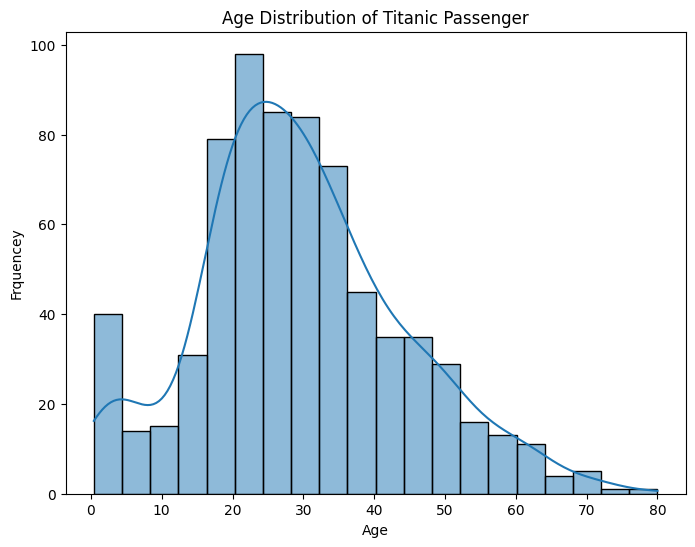

In [6]:
print("Distribution of Age Column:")
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.histplot(df_titanic["Age"], kde = True, bins = 20)
plt.title("Age Distribution of Titanic Passenger")
plt.xlabel("Age")
plt.ylabel("Frquencey")
plt.show()
#We will use Median as the feature values are right skewed

Distribution of Embarked Column:


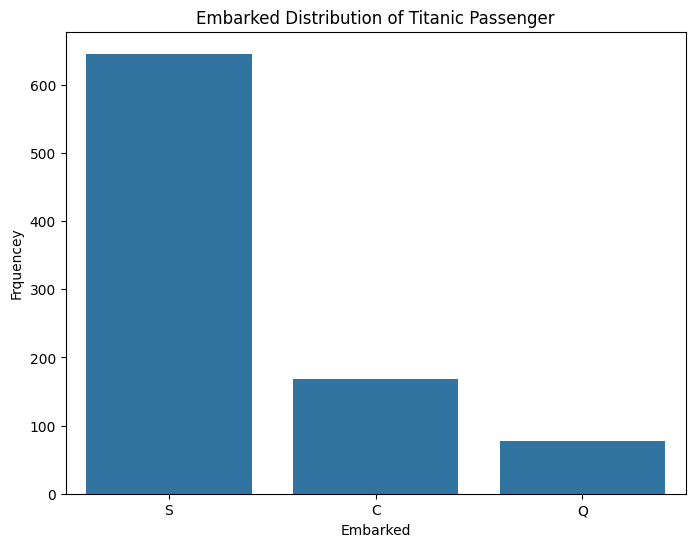

In [13]:
print("Distribution of Embarked Column:")
plt.figure(figsize=(8,6))
sns.countplot(data=df_titanic, x="Embarked")
plt.title("Embarked Distribution of Titanic Passenger")
plt.xlabel("Embarked")
plt.ylabel("Frquencey")
plt.show()
#

In [14]:
# 1. Handle numeric missing values: Age
age_median = df_titanic["Age"].median()
df_titanic["Age"] = df_titanic["Age"].fillna(age_median)

# 2. Handle categorical missing values: Embarked
embarked_mode = df_titanic["Embarked"].mode()[0]
df_titanic["Embarked"] = df_titanic["Embarked"].fillna(embarked_mode)

# 3. Drop Cabin (too many missing values)
# Drop Cabin only if it exists
if "Cabin" in df_titanic.columns:
    df_titanic = df_titanic.drop(columns=["Cabin"])
else:
    print("Cabin column does not exist.")


Cabin column does not exist.


In [ ]:
print("Missing values after handling:")
df_titanic.isnull().sum()

Missing values after handling:


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


###Encoding Categorical Variables (Heart Dataset)

Real-life analogy: **canteen token system**.

- The canteen menu has items like *Tehari*, *Chowmein*, *Biriyani*.
- The billing machine cannot understand these strings; it needs numeric codes.
- However, assigning `Tehari = 1`, `Chowmein = 2`, `Biriyani = 3` does **not**
  mean Biriyani is greater than Tehari. The numbers are **labels, not ranks**.

In the Heart dataset, we will:
- Use **Label Encoding** for binary categories like `Sex` and `ExerciseAngina`
- Use **OneHot Encoding** for nominal categories like `ChestPainType`,
  `RestingECG`, and `ST_Slope`

In [16]:
from sklearn.preprocessing import LabelEncoder
from google.colab import files
uploaded = files.upload()


# Load Heart dataset
heart_path = "heart.csv"  # change if needed
df_heart = pd.read_csv(heart_path)

print("First 10 rows of Heart dataset:")
display(df_heart.head(10))

print("\nColumn data types:")
display(df_heart.dtypes)

Saving heart.csv to heart.csv
First 10 rows of Heart dataset:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0



Column data types:


,0
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


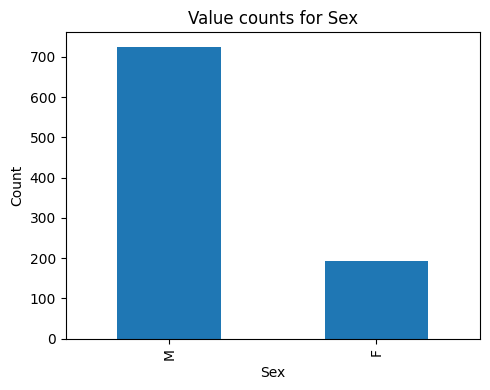

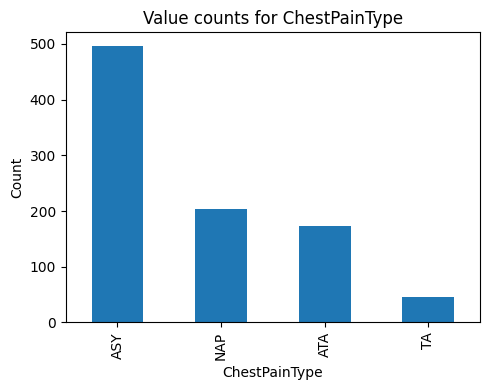

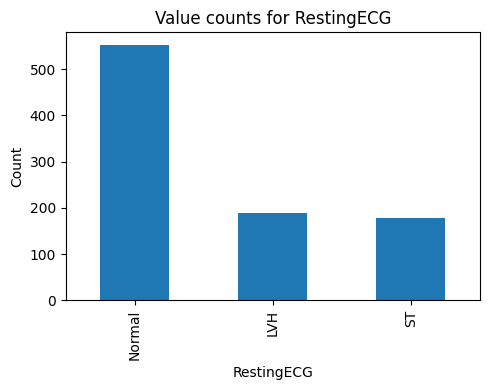

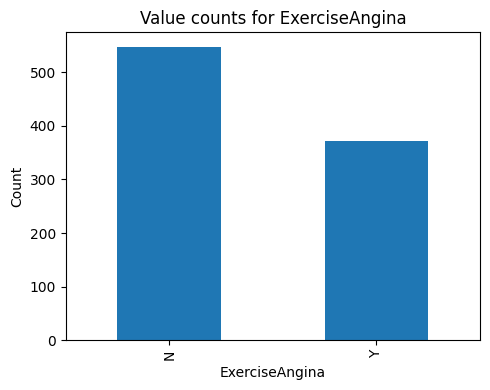

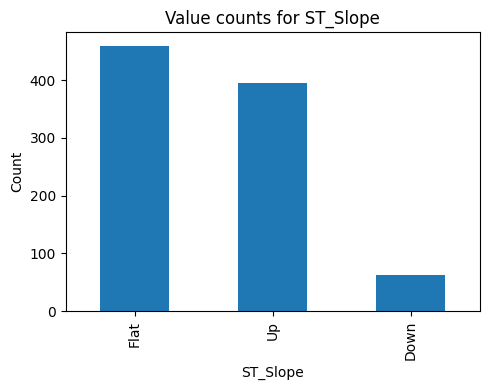

In [17]:
#Categorical Feature Exploration
categorical_cols = ["Sex", "ChestPainType", "RestingECG",
                    "ExerciseAngina", "ST_Slope"]
for c in categorical_cols:
  plt.figure(figsize=(5,4))
  df_heart[c].value_counts().plot(kind="bar")
  plt.title(f"Value counts for {c}")
  plt.ylabel("Count")
  plt.tight_layout()
  plt.show()

In [19]:
# Label Encoding for binary categorical columns -> Sex and ExerciseAngina
le = LabelEncoder()
df_heart["Sex"] = le.fit_transform(df_heart["Sex"])
df_heart["ExerciseAngina"] = le.fit_transform(df_heart["ExerciseAngina"])

In [ ]:
df_heart.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0
5,39,1,NAP,120,339,0,Normal,170,0,0.0,Up,0
6,45,0,ATA,130,237,0,Normal,170,0,0.0,Up,0
7,54,1,ATA,110,208,0,Normal,142,0,0.0,Up,0
8,37,1,ASY,140,207,0,Normal,130,1,1.5,Flat,1
9,48,0,ATA,120,284,0,Normal,120,0,0.0,Up,0


In [21]:
# OneHot Encoding for nominal categorical columns
cat_cols = ["ChestPainType", "RestingECG", "ST_Slope"]

df_heart_encoded = pd.get_dummies(
    df_heart,
    columns = cat_cols,
    dtype=int
)

In [22]:
df_heart_encoded.head(10)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1
5,39,1,120,339,0,170,0,0.0,0,0,0,1,0,0,1,0,0,0,1
6,45,0,130,237,0,170,0,0.0,0,0,1,0,0,0,1,0,0,0,1
7,54,1,110,208,0,142,0,0.0,0,0,1,0,0,0,1,0,0,0,1
8,37,1,140,207,0,130,1,1.5,1,1,0,0,0,0,1,0,0,1,0
9,48,0,120,284,0,120,0,0.0,0,0,1,0,0,0,1,0,0,0,1


###Normalization and Scaling

Real-life analogy: **comparing salary and height**.

- Height might range from 150 to 190 cm.
- Salary might range from 20,000 to 700,000.
- If we feed these two features directly into a distance-based model,
  salary will dominate the calculation.

To fix this, we **scale** numeric features so they are on a comparable range.

Common approaches:
- **StandardScaler**: transforms features to have mean 0 and standard deviation 1
- **MinMaxScaler**: rescales features to a fixed range, usually [0, 1]

Always fit the scaler on the **training set only**, then transform both
training and test sets using the same scaler.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Assume df_heart_encoded is our working dataframe with target 'HeartDisease'
target_col = "HeartDisease"

X = df_heart_encoded.drop(columns=[target_col])
y = df_heart_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

# Standard Scaling
scaler_sd = StandardScaler()
X_train_std = scaler_sd.fit_transform(X_train)#mean and SD will be calcualted from X_train
X_test_std = scaler_sd.transform(X_test)

# MinMax Scaling
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)



print("\n--- Displaying Standard Scaled Data ---")
# Convert scaled arrays back to DataFrame for better visualization with column names
X_train_std_df = pd.DataFrame(X_train_std, columns = X_train.columns, index = X_train.index)
X_test_std_df = pd.DataFrame(X_test_std, columns = X_test.columns, index = X_test.index)
print("\nFirst 5 rows of X_train & X_test (Standard Scaled):")
display(X_train_std_df.head())
display(X_test_std_df.head())


print("\n--- Displaying Standard Scaled Data ---")
# Convert scaled arrays back to DataFrame for better visualization with column names
X_train_mm_df = pd.DataFrame(X_train_mm, columns = X_train.columns, index = X_train.index)
X_test_mm_df = pd.DataFrame(X_test_mm, columns = X_test.columns, index = X_test.index)

print("\nFirst 5 rows of X_train (Minmax Scaled):")
display(X_train_mm_df.head())
display(X_test_mm_df.head())


--- Displaying Standard Scaled Data ---

First 5 rows of X_train & X_test (Standard Scaled):


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
155,0.239292,0.537019,1.183802,1.307314,1.877849,0.551672,1.182037,1.900458,0.905597,-0.480384,-0.530275,-0.213524,-0.505445,0.816002,-0.494088,-0.254981,0.962897,-0.851064
362,0.239292,0.537019,1.183802,-1.878000,-0.532524,-1.486343,-0.845997,-0.834739,-1.104244,-0.480384,1.885813,-0.213524,-0.505445,-1.225487,2.023931,-0.254981,0.962897,-0.851064
869,0.558968,0.537019,0.913811,0.096522,1.877849,0.831400,-0.845997,0.624033,-1.104244,-0.480384,1.885813,-0.213524,-0.505445,0.816002,-0.494088,-0.254981,-1.038533,1.174999
101,-0.293501,0.537019,-0.166155,-0.210833,-0.532524,-1.446382,-0.845997,-0.834739,0.905597,-0.480384,-0.530275,-0.213524,-0.505445,0.816002,-0.494088,-0.254981,-1.038533,1.174999
199,0.345851,-1.862131,-0.166155,0.990645,-0.532524,-1.526304,-0.845997,0.076994,-1.104244,-0.480384,-0.530275,4.683304,-0.505445,0.816002,-0.494088,-0.254981,0.962897,-0.851064


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
668,0.985202,-1.862131,0.373828,-0.061812,-0.532524,1.710544,-0.845997,-0.834739,-1.104244,2.081666,-0.530275,-0.213524,-0.505445,0.816002,-0.494088,-0.254981,-1.038533,1.174999
30,-0.080384,0.537019,0.643819,2.946539,-0.532524,-0.247550,-0.845997,-0.834739,-1.104244,-0.480384,1.885813,-0.213524,-0.505445,0.816002,-0.494088,-0.254981,0.962897,-0.851064
377,1.198319,0.537019,1.453793,-1.878000,1.877849,-0.567238,-0.845997,0.259340,0.905597,-0.480384,-0.530275,-0.213524,-0.505445,-1.225487,2.023931,-0.254981,0.962897,-0.851064
535,0.239292,0.537019,-0.166155,-1.878000,-0.532524,-0.567238,1.182037,0.076994,0.905597,-0.480384,-0.530275,-0.213524,1.978455,-1.225487,-0.494088,-0.254981,0.962897,-0.851064
807,0.026175,0.537019,-1.354116,0.999959,-0.532524,0.791439,-0.845997,-0.834739,-1.104244,2.081666,-0.530275,-0.213524,-0.505445,0.816002,-0.494088,-0.254981,-1.038533,1.174999



--- Displaying Standard Scaled Data ---

First 5 rows of X_train (Minmax Scaled):


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
155,0.562500,1.0,0.775,0.567164,1.0,0.674419,1.0,0.636364,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
362,0.562500,1.0,0.775,0.000000,0.0,0.279070,0.0,0.295455,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
869,0.625000,1.0,0.750,0.351575,1.0,0.728682,0.0,0.477273,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
101,0.458333,1.0,0.650,0.296849,0.0,0.286822,0.0,0.295455,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
199,0.583333,0.0,0.650,0.510779,0.0,0.271318,0.0,0.409091,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
668,0.708333,0.0,0.700,0.323383,0.0,0.899225,0.0,0.295455,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
30,0.500000,1.0,0.725,0.859038,0.0,0.519380,0.0,0.295455,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
377,0.750000,1.0,0.800,0.000000,1.0,0.457364,0.0,0.431818,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
535,0.562500,1.0,0.650,0.000000,0.0,0.457364,1.0,0.409091,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
807,0.520833,1.0,0.540,0.512438,0.0,0.720930,0.0,0.295455,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


---
## Part 2: Outliers, Transformations, Pipelines, and Sanity Check

In Part 2 we cover:
- Outlier detection and handling
- Feature transformation (polynomial, binning)
- Domain-driven feature construction
- Building a full preprocessing + modeling pipeline
- Running a quick sanity check with a simple model

###Outlier Detection and Handling

Real-life analogy: **a student scoring 500 out of 100**.

- Most students score between 60 and 90.
- One student has a recorded score of 500.
- This is likely a data entry error or an outlier.

If we include this in the average, the class average becomes meaningless.
Similarly, in ML, extreme values can distort models.

We will:
- Visualize outliers with a boxplot
- Use the **IQR method** to detect outliers
- Demonstrate removal, capping, and transformation approaches

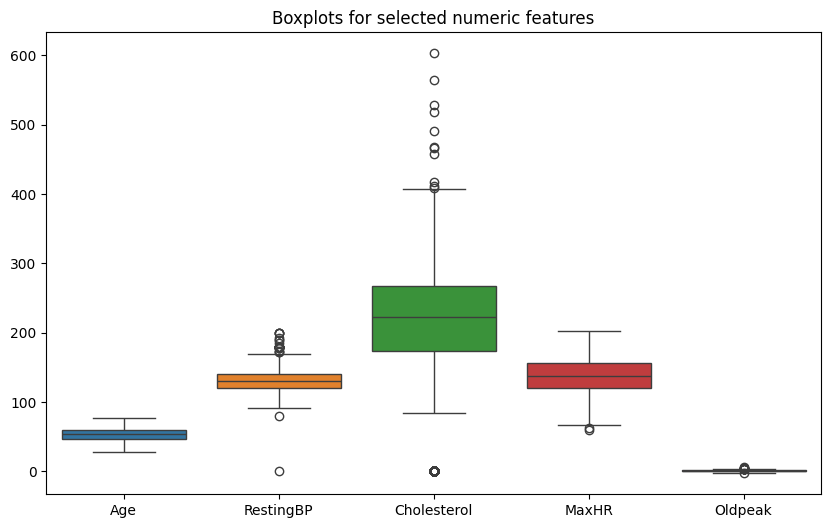

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize some numeric columns
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_heart_encoded[numeric_cols])
plt.title("Boxplots for selected numeric features")
plt.show()

In [26]:
# Use IQR method on Cholesterol as an example
col = "Cholesterol"
Q1 = df_heart_encoded[col].quantile(0.25)
Q3 = df_heart_encoded[col].quantile(0.75)
IQR = Q3-Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

outliers = df_heart_encoded[(df_heart_encoded[col]<lower) | (df_heart_encoded[col]>upper)]
print(f"Numer of detected outliers in {col}: ", len(outliers))

Numer of detected outliers in Cholesterol:  183


In [28]:
# 1. Remove outliers
df_no_outliers = df_heart_encoded[(df_heart_encoded[col] >=lower) & (df_heart_encoded[col] <=upper)]

# 2. Cap outliers (winsorization-like approach)
df_capped = df_heart_encoded.copy()
df_capped[col] = df_capped[col].clip(lower, upper)

# 3. Log transform the column (for skewed distributions)
df_log = df_heart_encoded.copy()
df_log[col + "_log"] = np.log(df_log[col]+1)


print(len(df_no_outliers))
print(df_capped)
print(df_log)

735
     Age  Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0     40    1        140        289.0          0    172               0   
1     49    0        160        180.0          0    156               0   
2     37    1        130        283.0          0     98               0   
3     48    0        138        214.0          0    108               1   
4     54    1        150        195.0          0    122               0   
..   ...  ...        ...          ...        ...    ...             ...   
913   45    1        110        264.0          0    132               0   
914   68    1        144        193.0          1    141               0   
915   57    1        130        131.0          0    115               1   
916   57    0        130        236.0          0    174               0   
917   38    1        138        175.0          0    173               0   

     Oldpeak  HeartDisease  ChestPainType_ASY  ChestPainType_ATA  \
0        0.0             0 

###Feature Transformation and Domain-Driven Features

Real-life analogy: **electricity bill categories**.

- Monthly bills: 2400, 2600, 2800, 3000, 9000, 2700.
- As raw numbers, it is hard to see a pattern.
- If we convert them to categories (LOW, MEDIUM, HIGH),
  it becomes easier to understand behavior.

In this section we:
- Create **polynomial features** to capture non-linear relationships
- Use **binning** to create groups from continuous variables
- Create **domain-driven features** such as blood pressure risk levels

In [29]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features using Age and MaxHR (if available)
poly_cols=["Age","MaxHR"]
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(df_heart_encoded[poly_cols])
poly_feature_names = poly.get_feature_names_out(poly_cols)

print(poly_feature_names)
print(poly_features.shape)

['Age' 'MaxHR' 'Age^2' 'Age MaxHR' 'MaxHR^2']
(918, 5)


In [30]:
# Binning Age into categories (Young, Middle, Old)
df_heart_encoded["Age_bin"] = pd.cut(
    df_heart_encoded["Age"],
    bins=[0,30,50,70,100],
    labels=["Young", "Middle", "Middle Old", "Old"]
)
print(df_heart_encoded[["Age", "Age_bin"]].head(50))

    Age     Age_bin
0    40      Middle
1    49      Middle
2    37      Middle
3    48      Middle
4    54  Middle Old
5    39      Middle
6    45      Middle
7    54  Middle Old
8    37      Middle
9    48      Middle
10   37      Middle
11   58  Middle Old
12   39      Middle
13   49      Middle
14   42      Middle
15   54  Middle Old
16   38      Middle
17   43      Middle
18   60  Middle Old
19   36      Middle
20   43      Middle
21   44      Middle
22   49      Middle
23   44      Middle
24   40      Middle
25   36      Middle
26   53  Middle Old
27   52  Middle Old
28   53  Middle Old
29   51  Middle Old
30   53  Middle Old
31   56  Middle Old
32   54  Middle Old
33   41      Middle
34   43      Middle
35   32      Middle
36   65  Middle Old
37   41      Middle
38   48      Middle
39   48      Middle
40   54  Middle Old
41   54  Middle Old
42   35      Middle
43   52  Middle Old
44   43      Middle
45   59  Middle Old
46   37      Middle
47   50      Middle
48   36      Middle


In [36]:
# Domain-driven risk categories for RestingBP and Oldpeak
def bp_risk(bp):
  if bp<120:
    return "Normal"
  elif bp<140:
    return "Elevated"
  else:
    return "High"

def oldpeak_risk(op):
  if op==0:
    return "No Stress"
  elif op<2:
    return "Moderate Stress"
  else:
    return "High Stress"

df_heart_encoded["BP_Risk"]=df_heart_encoded["RestingBP"].apply(bp_risk)
df_heart_encoded["Oldpeak_Risk"]=df_heart_encoded["Oldpeak"].apply(oldpeak_risk)
df_heart_encoded[["RestingBP", "BP_Risk", "Oldpeak","Oldpeak_Risk"]]

,RestingBP,BP_Risk,Oldpeak,Oldpeak_Risk
0,140,High,0.0,No Stress
1,160,High,1.0,Moderate Stress
2,130,Elevated,0.0,No Stress
3,138,Elevated,1.5,Moderate Stress
4,150,High,0.0,No Stress
...,...,...,...,...
913,110,Normal,1.2,Moderate Stress
914,144,High,3.4,High Stress
915,130,Elevated,1.2,Moderate Stress
916,130,Elevated,0.0,No Stress


###Putting It All Together in a Preprocessing Pipeline

Real-life analogy: **garments factory assembly line**.

- Cutting → Stitching → Printing → Ironing → Packaging.
- Each step must happen in the correct order.
- A pipeline in ML ensures preprocessing and modeling steps run
  in a fixed sequence without mixing training and test data.

We will:
- Build separate pipelines for numeric and categorical features
- Combine them using `ColumnTransformer`
- Attach a simple model (Logistic Regression) at the end
  to create a full pipeline.

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define numeric and categorical columns for the pipeline
num_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
cat_features = ["Sex", "ExerciseAngina", "ChestPainType", "RestingECG", "ST_Slope"]

# Numeric pipeline
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("ohe",OneHotEncoder(drop="first"))
])

# Combine both
preprocess = ColumnTransformer([
    ("num",num_pipeline,num_features),
    ("cat",cat_pipeline,cat_features)
])

# Full pipeline with a simple model
clf = Pipeline([
   ("prep",preprocess),
   ("model",LogisticRegression(max_iter=1000))
])


###Quick Sanity Check with a Simple Model

Real-life analogy: **test-driving a car before buying it**.

- You do not buy a car based only on brochures.
- You take it for a test drive to see if everything works as expected.

Similarly, before building complex models, we run a simple model (e.g.,
Logistic Regression) with our preprocessing pipeline to ensure:
- The pipeline runs without errors
- There is no data leakage
- The accuracy is reasonable for a first attempt

This is not the final model, just a **sanity check**.

In [38]:
# Train-test split using original df_heart (not already encoded)

X = df_heart.drop(columns=[target_col])
y = df_heart[target_col]

X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)

# Fit the full pipeline
clf.fit(X_train_pipe, y_train_pipe)

# Predict and evaluate
from sklearn.metrics import accuracy_score

y_pred_pipe = clf.predict(X_test_pipe)
acc=accuracy_score(y_test_pipe,y_pred_pipe)
print("Logistic Regression with preprocessing pipeline: ", acc)

Logistic Regression with preprocessing pipeline:  0.8434782608695652
